# Superstition

Superstition is a strategy that blindly trusts analyst's estinmates and recommendations. When trained on 2002-2012 and tested on 2012-2016 relative extreme multi-class data, the best tuned model yields 1.90 sharpe ratio for 3 month return prediction at market neutral position with `n_estimators=10`, `max_depth=5`.

In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
pd.options.mode.chained_assignment = None
np.seterr(divide="ignore", invalid="ignore")
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(context="notebook", style="whitegrid", color_codes=True)
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import warnings
warnings.filterwarnings("ignore")
from build import build_features
from build import build_labels
from build import build_train_test
from backtest import backtest_report

In [2]:
def superstition(df):
    df.dropna(how="all", subset=["numest", "suescore", "medrec"], inplace=True)
    df.eval(
        """
        diff_high = (prccd - ptghigh) / prccd
        diff_med = (prccd - medptg) / prccd
        diff_low = (prccd - ptglow) / prccd
        """,
        inplace=True,
    )
    return df.loc[
        (df.mcap > 1e6) & (df.prccd > 5),
        ["numest",
        "numdown1m",
        "numup1m",
        "diff_high",
        "diff_med",
        "diff_low",
        "suescore",
        "medrec",
        "numdown",
        "numup",
        "numrec",
        "buypct",
        "holdpct",
        "sellpct",
        ],
    ]

In [3]:
# read backtest data
backtest_data=pd.read_parquet("../data/backtest-0.1.1.parquet")
# select stocks with market cap > 1 million, trading price > 5 as stock universe
raw_data = pd.read_parquet("../data/raw-0.1.parquet")
gvkeys = raw_data[(raw_data.mcap > 1e6) & (raw_data.prccd > 5)].index.get_level_values("gvkey").unique()
universe = raw_data.loc[gvkeys]

In [4]:
features = build_features(universe, superstition, scale="rank")

In [5]:
labels = build_labels(universe, months=3, relative=True)

In [6]:
X_train, y_train, X_test, y_test = build_train_test(
    features,
    labels,
    train_start="2002-01-01",
    train_end="2012-01-01",
    test_start="2011-12-01",
    test_end="2016-01-01",
    method="multi",
    thres=0.1, 
    extreme=True,
    lower=0.2,
    upper=0.8)

Classification report on training set:

              precision    recall  f1-score   support

          -1       0.58      0.49      0.53     20136
           0       1.00      0.00      0.00      3516
           1       0.55      0.72      0.62     21308

    accuracy                           0.56     44960
   macro avg       0.71      0.40      0.38     44960
weighted avg       0.59      0.56      0.53     44960

Classification report on test set:

              precision    recall  f1-score   support

          -1       0.22      0.39      0.28      6888
           0       0.00      0.00      0.00     25448
           1       0.20      0.73      0.32      7773

    accuracy                           0.21     40109
   macro avg       0.14      0.37      0.20     40109
weighted avg       0.08      0.21      0.11     40109



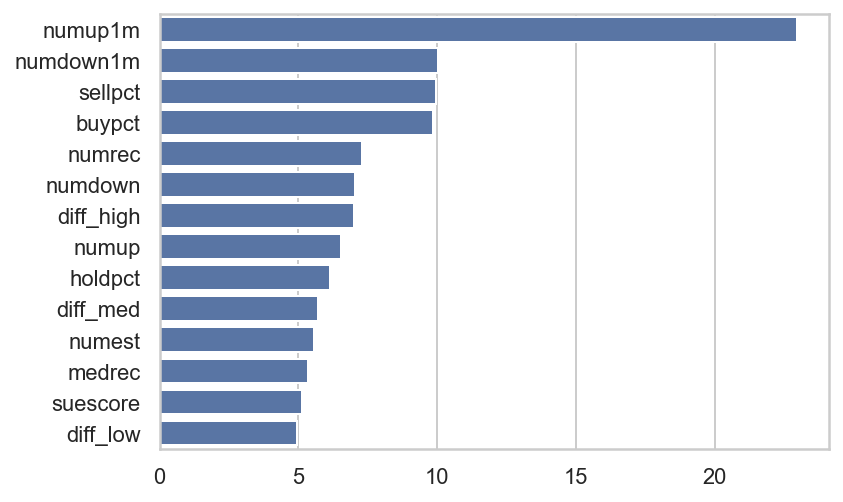

In [7]:
xgb_clf = XGBClassifier(n_estimators=10, max_depth=5, eval_metric="logloss", n_jobs=-1)
xgb_fit = xgb_clf.fit(X_train, y_train)
importance = pd.Series(data=xgb_clf.get_booster().get_score(importance_type="gain")).sort_values(ascending=False)
ax = sns.barplot(x=importance, y=importance.index, color="b")
print(f"Classification report on training set:\n")
print(classification_report(y_train, xgb_clf.predict(X_train)))
print(f"Classification report on test set:\n")
print(classification_report(y_test, xgb_clf.predict(X_test)))

Short Only Sharpe Ratio: 0.4120456619514299
Short Long Sharpe Ratio: 1.9019997768995431
Long Only Sharpe Ratio: 1.3900763817698656


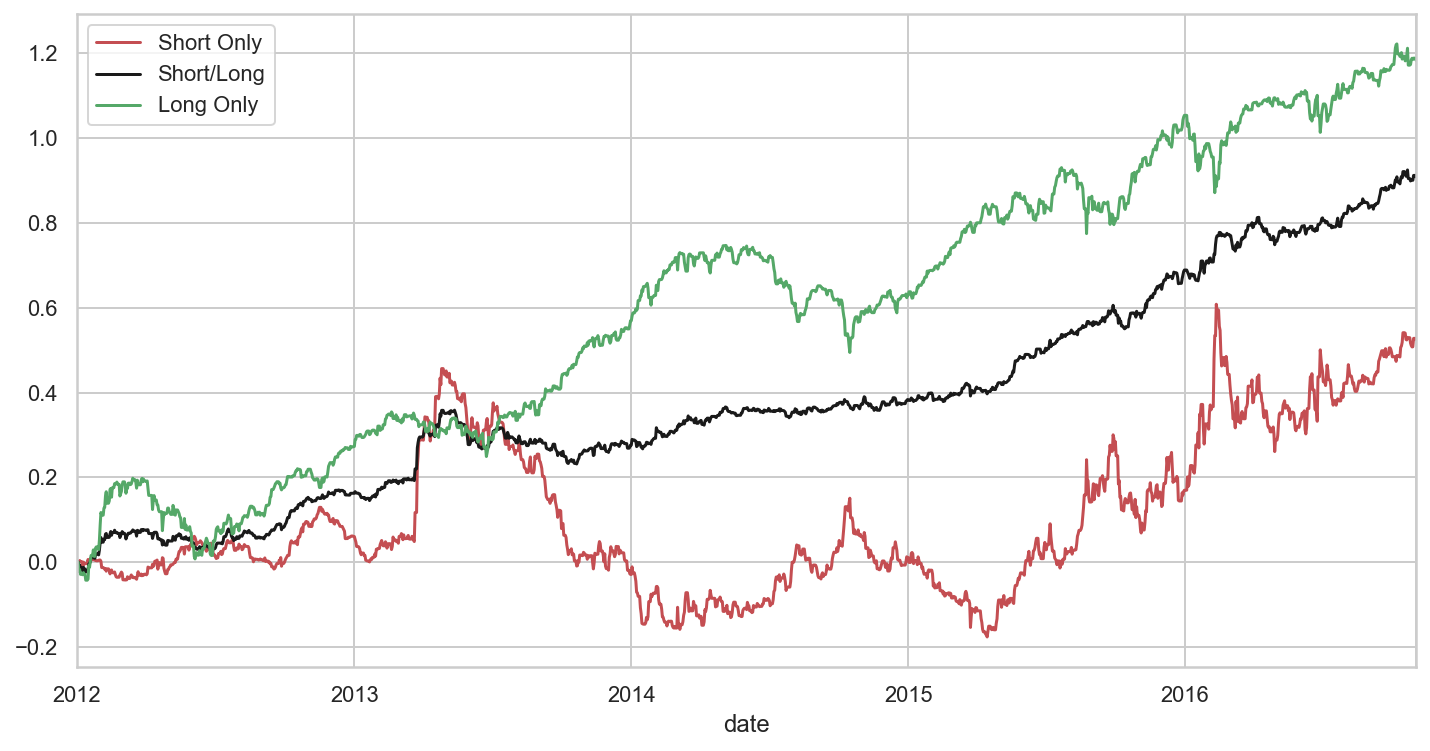

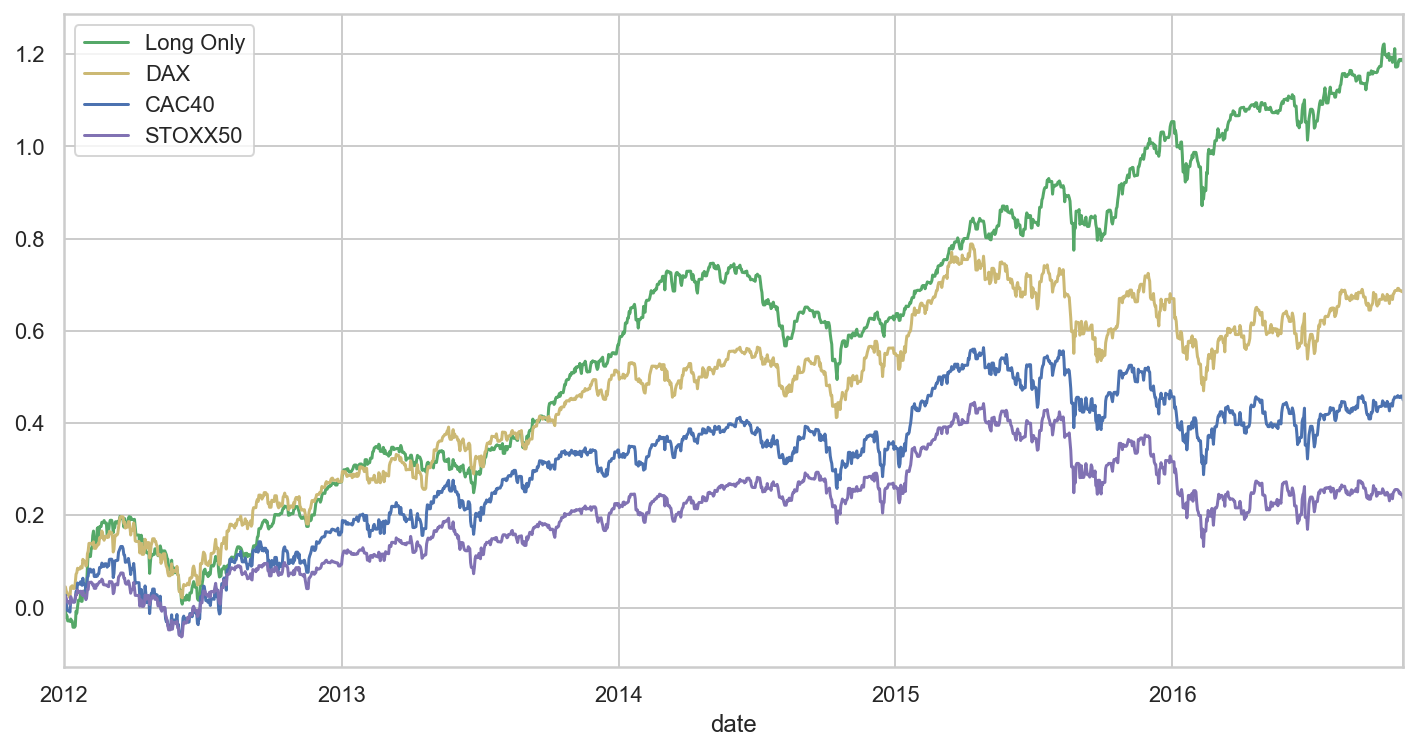

In [8]:
backtest_report(
    backtest_data,
    features,
    xgb_clf,
    test_start="2011-12-01",
    test_end="2016-01-01",
    months=3,
    n=10,
    weight="equal",
    method="percent")